In [1]:
from typing import Annotated,Sequence,TypedDict,List
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.graph import StateGraph,START,END
from langchain_community.chat_models import ChatTongyi
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from dashscope import TextEmbedding
from langchain_community.embeddings import DashScopeEmbeddings
import os

load_dotenv()

True

In [2]:

llm= ChatTongyi(model="qwen-plus")
embeddings = DashScopeEmbeddings(
    model="text-embedding-v3"
)
pdf_path="./Stock_Market_Performance_2024.pdf"
pdf_loader = PyPDFLoader(pdf_path)
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise


PDF has been loaded and has 9 pages


In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
pages_split = text_splitter.split_documents(pages) # We now apply this to our pages
persist_directory = r"./stock_market"
collection_name = "stock_market"
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

In [5]:
print(len(pages_split))

24


In [6]:
try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise

Created ChromaDB vector store!


In [7]:
retriever =vectorstore.as_retriever(search_kwargs={"k":5})
@tool
def retriever_tool(quary :str) ->str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """
    docs=retriever.invoke(quary)
    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    results=[]
    for i ,doc in enumerate(docs):
        results.append(f"Dcoument {i+1} :\n {doc.page_content}")
    return "\n\n".join(results)

def should_continue(state :AgentState):
    """check the last massage contants tool call"""
    result=state["messages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

tools=[retriever_tool]

llm=llm.bind_tools(tools)


In [8]:
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""
def our_agent(state: AgentState) -> AgentState:
    """call llm in graph"""
    mess=state['messages']
    mess=[SystemMessage(content=system_prompt)]+mess
    mess=llm.invoke(mess)
    return {"messages":[mess]}



In [9]:
graph=StateGraph(AgentState)
graph.add_node("agent",our_agent)
graph.add_node("tool_node",ToolNode(tools))

graph.add_edge(START,"agent")
graph.add_conditional_edges("agent",should_continue,{False:END,True:"tool_node"})
graph.add_edge("tool_node","agent")
agent=graph.compile()

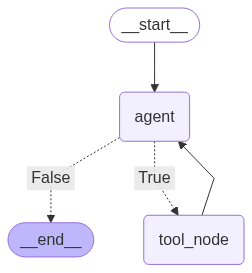

In [10]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))


In [20]:
import time
print("\n=== RAG AGENT===")
chat_history=[]
while True:
    user_input = input("\nWhat is your question: ")
    if user_input.lower() in ['exit', 'quit']:
        break
        
    messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type
    print(user_input)
    chat_history=chat_history+messages
    result =agent.invoke({"messages": chat_history})
    
    print("\n=== ANSWER ===")
    print(result['messages'][-1].content+"\n\n")
    chat_history.append(result["messages"][-1])
    time.sleep(1)


=== RAG AGENT===
我叫Bob

=== ANSWER ===
你好，Bob！如果你有关于2024年股市表现的问题，欢迎随时提问。我会根据加载的PDF文档为你提供准确的信息。请问有什么我可以帮助你的？


现在，我叫什么名字？

=== ANSWER ===
你现在叫Bob。有什么关于2024年股市表现的问题需要我帮忙解答吗？


这是关于哪个国家的股票？

=== ANSWER ===
这份文档主要讨论的是**美国**的股票市场表现。例如，文档中提到“2024年对股票来说是一个非常强劲的一年，美国股市延续了前一年的强劲涨势”，并且提到了S&P 500指数和Nasdaq Composite等美国市场的基准指数的表现。

此外，文档还提到了一些国际案例，比如英国的Arm Holdings (ARM)，这是一家在2024年表现优异的半导体IP和芯片设计公司。因此，虽然文档聚焦于美国股市，但也涵盖了部分国际市场的例子。




In [15]:
print(chat_history)

[HumanMessage(content='我叫什么名字', additional_kwargs={}, response_metadata={}, id='ae26ced4-085b-4c2e-a605-0c39d2149aa2'), AIMessage(content='您还没有告诉我您的名字呢！请告诉我，我将记得并使用它来更好地与您交流。', additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '8f0c3ee4-50db-9b14-9232-dea43803b4c8', 'token_usage': {'input_tokens': 274, 'output_tokens': 22, 'total_tokens': 296, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--bdc39c7d-67fe-4632-ac5d-6e8a92ce8794-0'), HumanMessage(content='我叫Bob', additional_kwargs={}, response_metadata={}, id='a56aac30-ff4c-4c63-bff2-839c04711f2d'), AIMessage(content='很高兴认识您，Bob！如果您有任何关于2024年股票市场表现的问题，请随时告诉我。', additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '0ed952ea-bef5-9cfc-9cfa-8c2367260be4', 'token_usage': {'input_tokens': 309, 'output_tokens': 22, 'total_tokens': 331, 'prompt_tokens_details': {'cached_tokens': 256}}}, id='run--842c5a69-4811-43a9-90b7-43b433